In [115]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [116]:
# download the dataset
import urllib.request

urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/05_Regularization/data/X_train.csv", "./data/X_train.csv")
urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/05_Regularization/data/y_train.csv", "./data/y_train.csv")
urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/05_Regularization/data/X_test.csv", "./data/X_test.csv")

X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')
X_test = pd.read_csv('./data/X_test.csv')

In [117]:
X = X_train
# makes it a 1D array
y = y_train.values.ravel()
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X, y, test_size=0.2, random_state=42)

In [118]:
# standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val_split)


### Use RidgeClassifier and combine polynomialFeatures for training in different degrees.

In [119]:
'''
Train the model in different degrees and alphas(complexity)
'''
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# set the degrees and alphas
degrees = [1, 2, 3]  # Linear, quadratic, cubic
alphas = [0.1, 100, 1000]

results = {}

# Combine the PolynomialFeatures and RidgeClassifier to train the model.
for degree in degrees:
    for alpha in alphas:
        model = make_pipeline(PolynomialFeatures(degree), RidgeClassifier(alpha=alpha))
        model.fit(X_train_scaled, y_train_split)
        
        # use the build-in score function to get the accuracy
        score = model.score(X_val_scaled, y_val_split)  
        results[(degree, alpha)] = score

for (degree, alpha), score in results.items():
    print(f'Degree: {degree}, Alpha: {alpha}, Validation Accuracy: {score:.4f}')



Degree: 1, Alpha: 0.1, Validation Accuracy: 0.6025
Degree: 1, Alpha: 100, Validation Accuracy: 0.6029
Degree: 1, Alpha: 1000, Validation Accuracy: 0.6032
Degree: 2, Alpha: 0.1, Validation Accuracy: 0.6113
Degree: 2, Alpha: 100, Validation Accuracy: 0.6117
Degree: 2, Alpha: 1000, Validation Accuracy: 0.6117
Degree: 3, Alpha: 0.1, Validation Accuracy: 0.6128
Degree: 3, Alpha: 100, Validation Accuracy: 0.6124
Degree: 3, Alpha: 1000, Validation Accuracy: 0.6124


### we can see from the results that the best model is the one with degree 3 and alpha 0.1 but the difference is very small.

In [120]:
# find the best alpha
best_alpha = max(results, key=results.get)
print("Best alpha:", best_alpha)

Best alpha: (3, 0.1)


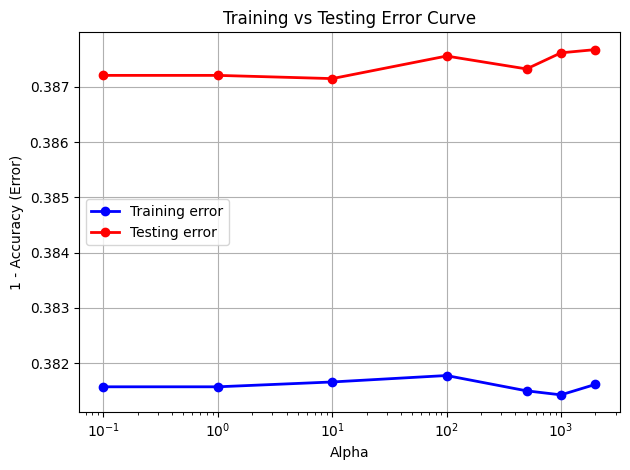

In [121]:
'''
Draw the error curve
'''
alphas = [0.1, 1, 10, 100, 500, 1000, 2000]

train_errors = []
test_errors = []

# the best degree
degree = 3

for alpha in alphas:
    model_plot = make_pipeline(PolynomialFeatures(degree), RidgeClassifier(alpha=alpha))
        
    model_plot.fit(X_train_scaled, y_train_split)
    
    y_train_pred = model_plot.predict(X_train_scaled)
    y_test_pred = model_plot.predict(X_val_scaled)
    
    # Compute 1 - accuracy (error rate) for both training and testing sets
    train_errors.append(1 - accuracy_score(y_train_split, y_train_pred))
    test_errors.append(1 - accuracy_score(y_val_split, y_test_pred))

# Plot the error curves
plt.plot(alphas, train_errors, label='Training error', color='blue', linewidth=2, marker='o')
plt.plot(alphas, test_errors, label='Testing error', color='red', linewidth=2, marker='o')

# Customizing the plot
plt.xscale('log')  # Use log scale for alpha
plt.xlabel('Alpha')
plt.ylabel('1 - Accuracy (Error)')
plt.title('Training vs Testing Error Curve')
plt.legend(loc='center left')
plt.grid(True)
plt.tight_layout()

plt.show()


### We can see the training error become really low around 500 to 1000 and the testing error gets high. This indicate the model is overfitting. The best alpha I choose is 0.1 which is not overfit.

In [122]:
# select the top 3 features
from sklearn.feature_selection import RFE
model = make_pipeline(PolynomialFeatures(3), RidgeClassifier(alpha=0.1))
model.fit(X_train_scaled, y_train_split)
rfe = RFE(estimator=model.named_steps['ridgeclassifier'], n_features_to_select=3)

rfe.fit(X_train_scaled, y_train_split)
top_3_features_rfe = X_train.columns[rfe.support_].tolist()

print("Top 3 features using RFE:", top_3_features_rfe)

Top 3 features using RFE: ['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']


### I use RFE (Recursive Feature Elimination) to select the feature. It involves a recusive feature elimination process.

In [123]:
X_top3_train = X_train[top_3_features_rfe]
X_top3_train_scaled = scaler.fit_transform(X_top3_train)
X_top3_train, X_top3_val, y_top3_train, y_top3_val = train_test_split(X_top3_train_scaled, y, test_size=0.2, random_state=42)
top3_model = RidgeClassifier(alpha=0.1).fit(X_top3_train, y_top3_train)

# show training error
score = top3_model.score(X_top3_val, y_top3_val)
print("training Accuracy using top3 feature:", score)

training Accuracy using top3 feature: 0.6046294676695236


### We can see from the accuracy above, it's quite similar to the accuracy training with all features. So these 3 features are quite important.

In [124]:
# Export the predictions of the model trained for X_test
top3_model.prediction = top3_model.predict(X_test[top_3_features_rfe].values)

# Create a DataFrame with the predictions and name the column "FGM"
predictions_df = pd.DataFrame(top3_model.prediction, columns=["FGM"])

# Export to CSV
predictions_df.to_csv("Lab05_113062574_y_pred.csv", header=True, index=False)
